In [1]:
from __future__ import annotations
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass
import graphviz
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random
from pprint import pprint
from typing import (Callable, Dict, Iterable, Generic, Sequence, Tuple,
                    Mapping, TypeVar, Set)

from rl.distribution import (Categorical, Distribution,
                            Gaussian, Choose, Constant, FiniteDistribution)
from rl.markov_process import MarkovProcess, FiniteMarkovProcess, NonTerminal, Terminal, State

from typing import Mapping, Dict

## State

State Space: 100 locations on a 10x10 game board.

Transition Probabilities: Equal probability of moving [1,2,3,4,5,6] steps ahead, combined with small probability of taking an additional [3,5,7,10] steps backwards or [2,3,5,7] steps forward. 

In [2]:
@dataclass(frozen=True)
class Die(Distribution[int]):
    sides: int
    def sample(self) -> int:
        return random.randint(1, self.sides)
    
    def expectation(self) -> int:
        return (int + 1) / 2

@dataclass(frozen=True)
class StateSaL:
    position: int
    
@dataclass
class SnakesandLadders(MarkovProcess[StateSaL]):
    # Create a distribution (a 6-sided die)
    six_sided = Die(6)
    snake = Choose([-10,-7,-5,-3])
    ladder = Choose([2,3,5,7])
    
    
    def transition(self, state: NonTerminal[StateSaL]) -> Categorical[State[StateSaL]]:
        die_roll = self.six_sided.sample()
        snake_s = self.snake.sample()
        ladder_s = self.ladder.sample()
        
        return Categorical({
            NonTerminal(StateSaL(state.state.position + die_roll)): 0.60,
            NonTerminal(StateSaL(state.state.position + die_roll + snake_s)): 0.20,
            NonTerminal(StateSaL(state.state.position + die_roll + ladder_s)): 0.20,
        })

## Test

In [3]:
def run_game(time_steps: int, num_traces: int) -> np.ndarray:
    mp = SnakesandLadders()
    start_state_distribution = Constant(NonTerminal(StateSaL(position=0)))
    
    return np.vstack([
        np.fromiter((s.state.position for s in itertools.islice(
            mp.simulate(start_state_distribution),
            time_steps + 1)), float) for _ in range(num_traces)])

In [4]:
game_traces: np.ndarray = run_game(
        time_steps=20,
        num_traces=10
    )

Text(0.5, 1.0, 'Location on Board')

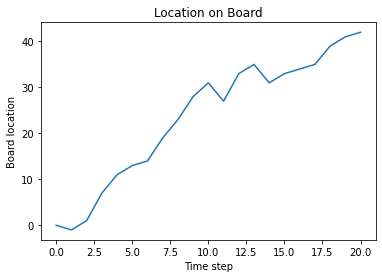

In [5]:
trace1 = game_traces[0]

plt.plot(trace1)
plt.ylabel("Board location")
plt.xlabel("Time step")
plt.title("Location on Board")

## Finite Markov Process

In [6]:

@dataclass(frozen=True)
class SaLState:
    position: int

    def get_position(self) -> int:
        return self.position


class SnakesandLaddersFinite(FiniteMarkovProcess[SaLState]):

    def __init__(self, board_size: int,):
        self.size: int = board_size
    
        # See above for Die distribution
        self.distr = Die(6)
        
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Mapping[SaLState, FiniteDistribution[SaLState]]:
        mymap: Dict[SaLState, Categorical[SaLState]] = {}
        
     
    
        for current_pos in range(self.size):
            current_state = SaLState(current_pos)
            
            # Probabilities just from the die rolls
            die_roll_map: Mapping[SaLState, float] = {
                SaLState(possible_pos): (1/6) * 0.8
                for possible_pos in range(current_pos+1, current_pos + 6)
                
            }
            
            # Probabilities from the snakes and ladders
            snake_and_ladder_map: Mapping[SaLState, float] = {
                SaLState(current_pos + offset): (1/5) * 0.2
                for offset in [-7,-5,-3,7,9] if (current_pos + offset >=0 and current_pos + offset <= self.size)
            }
            
            die_roll_map.update(snake_and_ladder_map)
            
            mymap[SaLState(current_pos)] = Categorical(die_roll_map)
        return mymap
    


# if __name__ == '__main__':
#     si_mp = SnakesandLaddersFinite(board_size=100)

#     print("Transition Map")
#     print("--------------")
#     print(si_mp)

#     print("Stationary Distribution")
#     print("-----------------------")
#     si_mp.display_stationary_distribution()


## Transition Map

In [7]:
Board1 = SnakesandLaddersFinite(board_size=100)

In [ ]:
print("Transition Map")
print("--------------")
print(Board1)

## Histogram

In [9]:
keys = list(Board1.transition_map.keys())
start_dist = Categorical({keys[0]:1})

In [10]:
traces = itertools.islice(Board1.traces(start_dist), 100000)

steps_per_trace = []
for trace in traces:
    steps = len(list(trace))
    steps_per_trace += [steps]

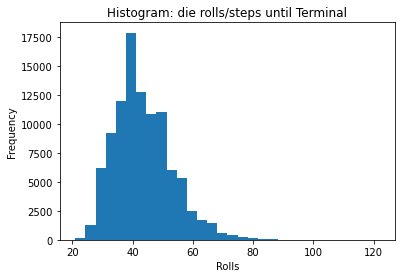

In [12]:
plt.hist(steps_per_trace, bins=30)
plt.title("Histogram: die rolls/steps until Terminal")
plt.ylabel("Frequency")
plt.xlabel("Rolls")
plt.show()

## Frog Puzzle

In [17]:
@dataclass(frozen=True)
class FrogState:
    position: int

class FrogPuzzle(FiniteMarkovProcess[FrogState]):

    def __init__(self, end: int,):
        self.end: int = end
    
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Mapping[FrogState, FiniteDistribution[FrogState]]:
        mymap: Dict[FrogState, Categorical[FrogState]] = {}
        
        for position in range(self.end):
            
            # Possibilities:
            transition_map: Mapping[FrogState, float] = {
                FrogState(possible_pos): 1 / (self.end+1-position)
                for possible_pos in range(position+1, self.end+1)
                
            }
            mymap[FrogState(position)] = Categorical(transition_map)
        return mymap

In [19]:
FrogGame = FrogPuzzle(end=10)

Expectation: 3.9265199999995333


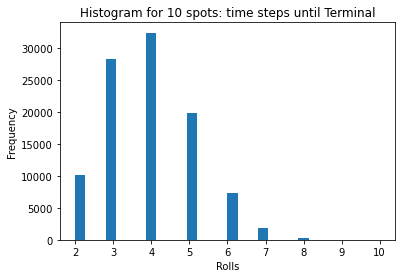

In [23]:
keys = list(FrogGame.transition_map.keys())
start_dist = Categorical({keys[0]:1})

num_traces = 100000
traces = itertools.islice(FrogGame.traces(start_dist), num_traces)

steps_per_trace = []
expectation = 0
for trace in traces:
    steps = len(list(trace))
    steps_per_trace += [steps]
    expectation += (steps * 1/num_traces)
    
print("Expectation: " + str(expectation))
    
plt.hist(steps_per_trace, bins=30)
plt.title("Histogram for 10 spots: time steps until Terminal")
plt.ylabel("Frequency")
plt.xlabel("Rolls")
plt.show()

In [25]:

num_spots = []
expectation_for_given_num_spots = []
for i in range(10,30):
    FrogGame = FrogPuzzle(end=i)
    
    keys = list(FrogGame.transition_map.keys())
    start_dist = Categorical({keys[0]:1})

    num_traces = 10000
    traces = itertools.islice(FrogGame.traces(start_dist), num_traces)

    steps_per_trace = []
    expectation = 0
    for trace in traces:
        steps = len(list(trace))
        steps_per_trace += [steps]
        expectation += (steps * 1/num_traces)

    print("Expectation for " + str(i) + " spots: " + str(expectation))
    
    num_spots += [i]
    expectation_for_given_num_spots += [expectation]

Expectation for 10 spots: 3.943900000000187
Expectation for 11 spots: 4.024200000000186
Expectation for 12 spots: 4.11660000000018
Expectation for 13 spots: 4.1924000000002035
Expectation for 14 spots: 4.237500000000197
Expectation for 15 spots: 4.3371000000001745
Expectation for 16 spots: 4.370700000000193
Expectation for 17 spots: 4.437200000000183
Expectation for 18 spots: 4.507800000000185
Expectation for 19 spots: 4.549900000000182
Expectation for 20 spots: 4.588200000000185
Expectation for 21 spots: 4.6444000000001795
Expectation for 22 spots: 4.690300000000178
Expectation for 23 spots: 4.7269000000001835
Expectation for 24 spots: 4.786100000000173
Expectation for 25 spots: 4.799600000000198
Expectation for 26 spots: 4.8724000000001935
Expectation for 27 spots: 4.893100000000183
Expectation for 28 spots: 4.9199000000001964
Expectation for 29 spots: 4.950000000000182


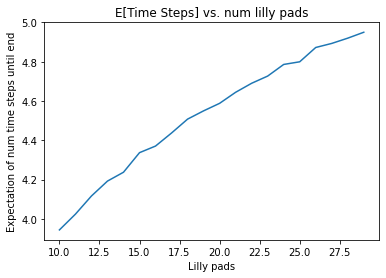

In [29]:
plt.plot(num_spots, expectation_for_given_num_spots)
plt.xlabel("Lilly pads")
plt.ylabel("Expectation of num time steps until end")
plt.title("E[Time Steps] vs. num lilly pads")
plt.show()